# Reproduction Package for "MeerKAT radio observations of the neutron star low-mass X-ray binary Cen X-4 at low accretion rates" by Van den Eijnden et al. (2022). 

This Notebook reproduces all figures and analysis that requires python 3.

The below code will, specifically, reproduce Figures 3 and 4. 

For the reproduction of Figures 1 and 2, as well as all the fits to the $L_X-L_R$ data (which are used in this python 3 notebook to reproduce Figure 4), see the other (python 2.7) notebook.

# Step 0) Loading the basic input for the code

In [1]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Arial Unicode.ttf'

In [2]:
# Loading of standard Python packages:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import LogNorm

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special
import scipy.stats as ST

import os
from astropy import units as u
from astropy.units import cds
from astropy.time import Time
cds.enable()  

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

# Basic plotting settings
single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS = 18
LS = 18
MS = 10
MEW= 1.5

%matplotlib inline

# Step 1) recreate the light curves of Figure 3

## X-ray data:

In [3]:
xray_data_folder = './Figure3/'

# Read in the X-ray lightcurve from the Swift pipeline:
MJD, Rx, dRx, Detx = np.genfromtxt(xray_data_folder+'pipeline_rates_lc.txt', unpack=True, usecols=[0,3,4,6])
ULx = []
for i in range(len(MJD)):
    if Detx[i] == 1:
        ULx.append(False)
    else:
        ULx.append(True)

# Read in the fluxes for all X-ray spectra, including one NICER spectrum. See the paper for details
# on the measurements of these fluxes.
obsid, date, time, Fx, dFx, frac = np.genfromtxt(xray_data_folder+'full_flux_lc.txt', unpack=True, usecols=[0,1,2,3,4,5], dtype='str')

# Converting the time and date of the flux measurements to MJD:
MJD_flux = []
for i in range(len(date)):
    MJD_flux.append(Time(date[i]+'T'+time[i], format='isot', scale='utc').mjd)
MJD_flux = np.asarray(MJD_flux)

# Converting the fluxes to the correct type
Fx = Fx.astype('float')
dFx = dFx.astype('float')
frac = frac.astype('float')

# Printing all X-ray flux data: note how the NICER observation has its own, fake (!) ObsID
for i in range(len(obsid)):
    print(obsid[i], '\t', np.round(MJD_flux[i],2), '\t', Fx[i], '\t', dFx[i])

00088937006 	 59118.52 	 3.4881889e-13 	 9.25722212e-14
00035324068 	 59211.46 	 2.945472e-12 	 6.4800384e-13
00035324069 	 59214.25 	 4.4646312e-12 	 1.83049879e-12
00035324070 	 59218.96 	 1.0921945e-11 	 1.15035517e-12
00035324071 	 59221.15 	 7.4113956e-12 	 1.49716875e-12
00035324072 	 59225.93 	 1.1797896e-12 	 1.41574752e-13
00035324074 	 59227.06 	 1.188278e-12 	 2.0200726e-13
00035324075 	 59228.13 	 1.34062569e-12 	 2.41312623e-13
00035324076 	 59229.98 	 1.9906921e-12 	 4.77766104e-13
00035324081 	 59233.76 	 8.918614e-13 	 1.51616438e-13
00035324082 	 59234.96 	 1.4977526e-12 	 3.14528046e-13
00035324084 	 59237.61 	 1.37970828e-12 	 3.17332904e-13
000NICER000 	 59223.46 	 3.225612e-12 	 1.9353672e-13


## Radio data:

In [4]:
# time:
MKAT_T = np.asarray(['2020-09-26T12:26:09','2021-01-07T10:19:01.7','2021-01-09T08:31:21.4','2021-01-16T07:40:59.3'])
MKAT_MJD = Time(MKAT_T, format='isot', scale='utc').mjd # convert to MJD

# flux density
F_UL = np.asarray([13.2,69.0,54.0,48.0]) # uJy/bm
dF_UL = F_UL/3. # All errors are the flux density / 3, since they are 3-sigma upper limits.

## Create the figure

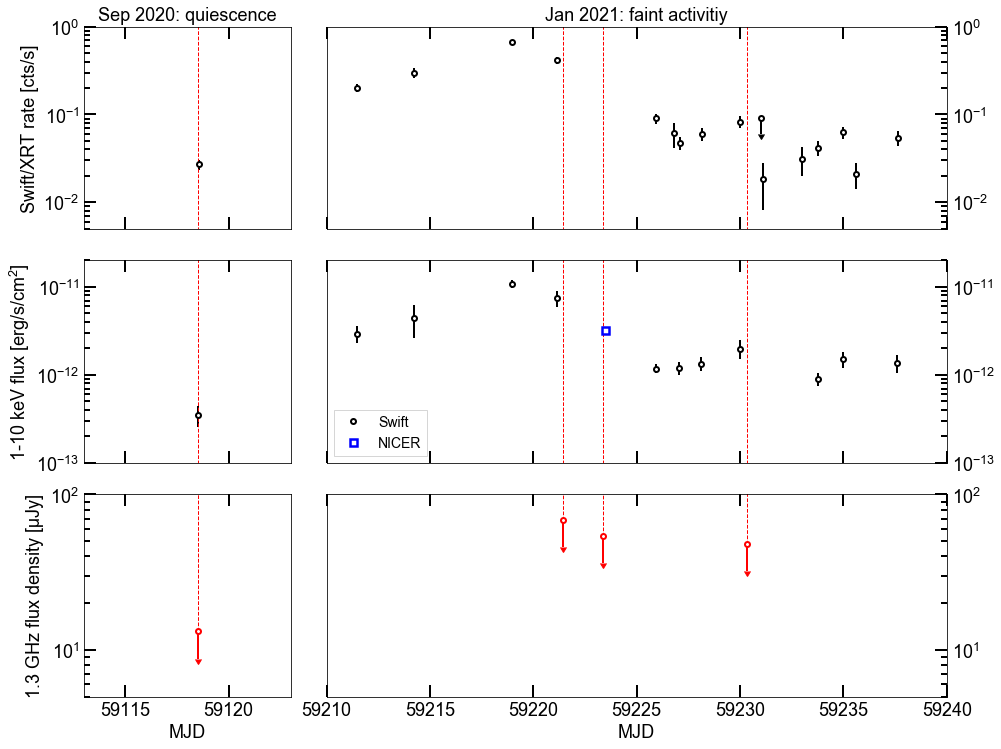

In [6]:
# The below code is all standard matplotlib. Gridspec ensures different sized for the left and right column.

fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(3.*single_col)))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 3]) 

ax1 = plt.subplot(gs[0])
ax1b = plt.subplot(gs[1])

ax2 = plt.subplot(gs[2])
ax2b = plt.subplot(gs[3])

ax3 = plt.subplot(gs[4])
ax3b = plt.subplot(gs[5])

########## SETUP ##########

for ax in [ax1,ax2,ax3,ax1b,ax2b,ax3b]:
    ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
    ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)

    ax.xaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(59113,59123)
    ax.yaxis.set_ticks_position('left')
    
for ax in [ax1b,ax2b,ax3b]:
    ax.yaxis.set_ticks_position('right')
    ax.set_xlim(59210,59240)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1b.set_xticklabels([])
ax2b.set_xticklabels([])

########## TOP PANEL ##########

for ax in [ax1,ax1b]:
    ax.errorbar(MJD, Rx, yerr=dRx, fmt='wo', ms=5, elinewidth=2, uplims=ULx, mew=2, mec='k')
    ax.errorbar(MJD, Rx, yerr=dRx, fmt='ko', ms=0, elinewidth=2, uplims=ULx)

    for t in MKAT_MJD:
        ax.plot([t,t], [0, 1e100], 'r--', lw=1)

    ax.set_yscale('log')
    ax.set_ylim(5e-3, 1.0)

ax1.set_ylabel(r'Swift/XRT rate [cts/s]', fontsize=FS)
ax1.set_title('Sep 2020: quiescence', fontsize=FS)
ax1b.set_title('Jan 2021: faint activitiy', fontsize=FS)

########## MIDDLE PANEL ##########

for ax in [ax2,ax2b]:
    ax.errorbar(MJD_flux, Fx, yerr=dFx, fmt='wo', ms=5, elinewidth=2, mew=2, mec='k', label='Swift')
    ax.errorbar(MJD_flux, Fx, yerr=dFx, fmt='ko', ms=0, elinewidth=2)
    
    ax.errorbar(MJD_flux[-1], Fx[-1], yerr=dFx[-1], fmt='ws', ms=7, elinewidth=2, mew=2.5, mec='b', label='NICER')
    ax.errorbar(MJD_flux[-1], Fx[-1], yerr=dFx[-1], fmt='bs', ms=0, elinewidth=2)

    for t in MKAT_MJD:
        ax.plot([t,t], [0, 1e100], 'r--', lw=1)

    ax.set_yscale('log')
    ax.set_ylim(1e-13, 2e-11)
    
ax2.set_ylabel(r'1-10 keV flux [erg/s/cm$^2$]', fontsize=FS)
ax2b.legend(loc=3, fontsize=FS-4, fancybox=False)

########## TOP PANEL ##########

for ax in [ax3,ax3b]:
    ax.errorbar(MKAT_MJD, F_UL, yerr=dF_UL, fmt='wo', ms=5, elinewidth=2, uplims=True, mew=2, mec='r')
    ax.errorbar(MKAT_MJD, F_UL, yerr=dF_UL, fmt='ro', ms=0, elinewidth=2, uplims=True)

    for i in range(len(MKAT_MJD)):
        ax.plot([MKAT_MJD[i],MKAT_MJD[i]], [F_UL[i], 1e100], 'r--', lw=1)

    ax.set_ylim(5., 100.)
    ax.set_yscale('log')
    
ax3.set_ylabel(r'1.3 GHz flux density [$\mu$Jy]', fontsize=FS)
ax3.set_xlabel(r'MJD', fontsize=FS)
ax3b.set_xlabel(r'MJD', fontsize=FS)

########## FINAL SETUP ##########

plt.tight_layout()
plt.savefig('Figure3/Figure3.png', dpi=500)

# Step 2) Recreate the $Lx - Lr$ plot of Figure 4

Note that the below code is, largely, based of the $L_X - L_R$ database by Bahramian et al. 2018 (see https://github.com/bersavosh/XRB-LrLx_pub). Adjustments are made to remove/add sources and show the fits (performed in the other notebook in python 2).

In [7]:
# For reading from the CSV file:
from astropy.io import ascii
import pickle

In [8]:
# BW print-friendly color palette adopted from CubeHelix by Matt Davis
colorset = ['#000000', '#00270C', '#00443C', '#005083', '#034BCA', '#483CFC', '#9C2BFF', '#EB24F4', '#FF2DC2', '#FF4986', '#FF7356', '#FFA443', '#EBD155', '#D3F187', '#D7FFC8', '#FFFFFF']

colorset = ['#000000', '#00270C', '0.50', '#005083', 'lightskyblue', '#483CFC', '#9C2BFF', '#EB24F4', '#FF2DC2', '#FF4986', '#FF7356', '#FFA443', '#EBD155', '#D3F187', '#D7FFC8', '#FFFFFF']

## Reading in all data:

In [9]:
# Loading the pre-compiled catalog in pickle format
src_list = pickle.load(open('./Figure4/lrlx_data.p', 'rb'), encoding='latin1')

In [10]:
# Defining the new data: the new limits on Cen X-4 from MeerKAT:
Lx_C4 = np.asarray([6.0e31, 1.3e33, 5.5e32, 3.5e32])
dLx_C4 = np.asarray([1.7e31, 0.3e33, 0.4e32, 0.9e32])
Lr_UL_C4 = np.asarray([1.1e26, 5.9e26, 4.7e26, 4.1e26])

In [14]:
# Reading in the Aql X-1 data from Gusinskaia et al. 2020 (Table A1)
# See https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.2858G/abstract

Lx_Aqx1, dLx_AqX1 = np.genfromtxt('./Figure4/aqlx1_lx.txt', unpack=True)
Lx_Aqx1 = Lx_Aqx1*1e36
dLx_AqX1 = dLx_AqX1*1e36

Lr_Aqx1, dLr_Aqx1 = np.genfromtxt('./Figure4/aqlx1_lr.txt', unpack=True)
Lr_UL_Aqx1 = []
for i in range(len(Lr_Aqx1)):
    if dLr_Aqx1[i] < 0:
        Lr_UL_Aqx1.append(True)
        dLr_Aqx1[i] = Lr_Aqx1[i]*0.50*1.0e28
    else:
        Lr_UL_Aqx1.append(False)
        dLr_Aqx1[i] = dLr_Aqx1[i]*1.0e28
Lr_Aqx1 = Lr_Aqx1 * 1e28
Lr_UL_Aqx1 = np.asarray(Lr_UL_Aqx1)

HR_Aqx1 = np.genfromtxt('./Figure4/aqlx1_HR.txt', unpack=True, usecols=[0])

# Shielding the points with low HR (following Gusinskaia + 2020), by setting their Lx to 1 erg/s 
# (so they are not visible in the figure)
for i in range(len(HR_Aqx1)):
    if HR_Aqx1[i] < 0.75:
        Lx_Aqx1[i] = 1.0

In [18]:
# LMXBs (except those in soft state) from Van den Eijnden et al. (2021), which are not yet in the database:
# Taken from Table 1, in the order of that table. 
# See https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.3899V/abstract

# When data is available at two frequencies, we use the one closest to 5 GHz. 
# Do not include XMMU J174716.1-281048 since it is not detected in either X-ray or radio band.

Fr_vdE21 = np.asarray([63.7, 30.0, 20.0, 21.0, 30., 2.6, 4.0, 431., 87., 14., 14., 21., 22., 24.])* u.microJansky
dFr_vdE21 = np.asarray([3.7, 15., 10., 10.5, 15., 1.3, 2.0, 7.0, 11.0, 7., 7., 10.5, 11., 12.])* u.microJansky

Fx_vdE21 = np.asarray([2e-9, 5.9e-9, 3.0e-10, 3.8e-10, 6.3e-11, 3.7e-12, 2.6e-12, 2.1e-10, 8.5e-11, 3e-12, 3.9e-11, 3e-12, 8.8e-13, 2.2e-12])* u.erg/u.second/(u.cm**2)
dFx_vdE21 = np.asarray([0.2e-9, 0.2e-9, 0.1e-10, 0.1e-10, 0.5e-11, 0.4e-12, 0.3e-12, 0.1e-10, 0.7e-11, 1e-12, 0.3e-11, 1e-12, 4.4e-13, 1.1e-12])* u.erg/u.second/(u.cm**2)

D_vdE21 = np.asarray([5., 8.5, 4., 4.3, 7.3, 9.5, 9.2, 8.0,8.0,8.0,8.0,8.0,8.0,8.0])*u.kpc

det_vdE21 = np.asarray([True, False, False, False, False, False, False, True, True, False, False, False, False, False])

Lx_vdE21 = (4.*np.pi*Fx_vdE21*(D_vdE21**2)).to(u.erg/u.second).value
dLx_vdE21 = (4.*np.pi*dFx_vdE21*(D_vdE21**2)).to(u.erg/u.second).value

Lr_vdE21 = (4.*np.pi*Fr_vdE21*(5*u.GHz)*(D_vdE21**2)).to(u.erg/u.second).value
dLr_vdE21 = (4.*np.pi*dFr_vdE21*(5*u.GHz)*(D_vdE21**2)).to(u.erg/u.second).value

In [19]:
# New data from MAVERIC survey by Panurach et al. 2021 
# See https://ui.adsabs.harvard.edu/abs/2021ApJ...923...88P/abstract
# Distances are taken from Tremou et al. 2018
# See https://ui.adsabs.harvard.edu/abs/2018ApJ...862...16T/abstract

Name_MAV = ['X1850-087', '4U1746-37', 'XB1832-330', 'GRS1747-312', 'GRS1747-312', 'GRS1747-312', 'M15_X-3']

Fr_MAV = np.asarray([12.9, 13.7, 6.6, 213., 12.9, 26.9, 16.1])* u.microJansky
dFr_MAV = np.asarray([6.45, 6.85, 3.3, 5.1, 6.45, 4.3, 8.05])* u.microJansky

Fx_MAV = np.asarray([1.6e-10, 8.6e-10, 1.9e-11, 5.3e-12, 8.0e-12, 0.9e-12, 3.5e-13])* u.erg/u.second/(u.cm**2)
dFx_MAV = np.asarray([0.1e-10, 2.0e-10, 0.1e-11, 4.0e-12, 4.8e-12, 0.6e-12, 1.4e-13])* u.erg/u.second/(u.cm**2)

D_MAV = np.asarray([8.0, 13.4, 10.0, 7.0, 7.0, 7.0, 10.3])*u.kpc

det_MAV = np.asarray([False, False, False, True, False, True, False])

Lx_MAV = (4.*np.pi*Fx_MAV*(D_MAV**2)).to(u.erg/u.second).value
dLx_MAV = (4.*np.pi*dFx_MAV*(D_MAV**2)).to(u.erg/u.second).value

Lr_MAV = (4.*np.pi*Fr_MAV*(5*u.GHz)*(D_MAV**2)).to(u.erg/u.second).value
dLr_MAV = (4.*np.pi*dFr_MAV*(5*u.GHz)*(D_MAV**2)).to(u.erg/u.second).value

In [21]:
# Data for the four tMSP candidates discussed in the paper:
# Taken from, respectively, Li et al. 2020, Jaodand et al. 2021, Paduano et al. 2021, Coti Zelati et al. 2021.
# (see the main manuscript for details on this data selection).
# See https://ui.adsabs.harvard.edu/abs/2020ApJ...895...89L/abstract
# https://ui.adsabs.harvard.edu/abs/2021ApJ...923....3J/abstract
# https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.4107P/abstract
# https://ui.adsabs.harvard.edu/abs/2021A%26A...655A..52C/abstract

Name_cand_tMSP = ['3FGL J0427.9-6704', '3FGL J1544.6-1125', 'NGC 6652B', 'CXOU J110926.4-650224']

Fr_cand_tMSP = np.asarray([290., 25.1, 79.2, 33.])* u.microJansky
dFr_cand_tMSP = np.asarray([7.0, 2.0, 2.2, 4.0])* u.microJansky

Fx_cand_tMSP = np.asarray([2.765e-12, 2.5e-12, 1.52e-12, 3.53e-12])* u.erg/u.second/(u.cm**2)
dFx_cand_tMSP = np.asarray([0.08e-12, 0.13e-12, 0.14e-12, 0.03e-12])* u.erg/u.second/(u.cm**2)

D_cand_tMSP = np.asarray([2.3, 3.8, 10., 4.])*u.kpc

det_cand_tMSP = np.asarray([True, True, True, True])

Lx_cand_tMSP = (4.*np.pi*Fx_cand_tMSP*(D_cand_tMSP**2)).to(u.erg/u.second).value
dLx_cand_tMSP = (4.*np.pi*dFx_cand_tMSP*(D_cand_tMSP**2)).to(u.erg/u.second).value

Lr_cand_tMSP = (4.*np.pi*Fr_cand_tMSP*(5*u.GHz)*(D_cand_tMSP**2)).to(u.erg/u.second).value
dLr_cand_tMSP = (4.*np.pi*dFr_cand_tMSP*(5*u.GHz)*(D_cand_tMSP**2)).to(u.erg/u.second).value

## Generating the plot
Note that this code is based on the original code, and adjusted to include/exclude sources, and show the fits.

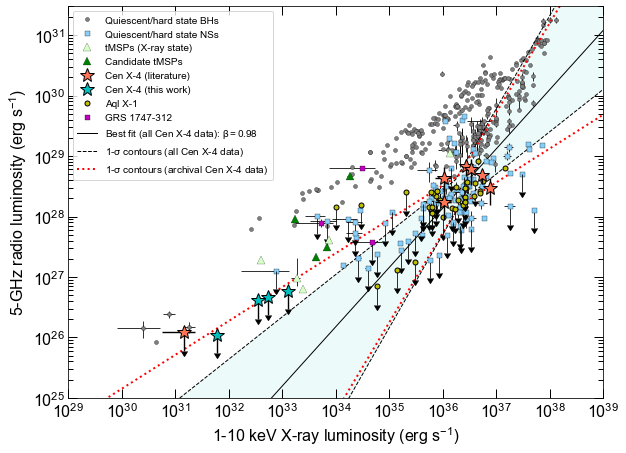

In [22]:
fig = plt.figure(figsize=(1.33*cm2inch(double_col), cm2inch(double_col)))
ax = fig.add_subplot(111)

for i in src_list:
    plotted=False

    # Plotting each class with different markers:
    if i['Class'] == 'BH':
        BHs,=ax.loglog(i['Lx'],i['Lr'],'o',ms=4, c=colorset[2],mec='k',zorder=2,mew=0.3,label='Quiescent/hard state BHs')
        plotted=True
    
    if i['Class'] == 'NS' or i['Class'] == 'AMXP':
        if i['Name'] != 'Cen X-4' and i['Name'] != 'Aqls X-1':
            NSs,=ax.loglog(i['Lx'],i['Lr'],'s',ms=5, c=colorset[4],mec='k',mew=0.3,zorder=3,label='Quiescent/hard state NSs')   
        elif i['Name'] == 'Cen X-4': 
            CenX4,=ax.loglog(i['Lx'],i['Lr'],'*',ms=15, c=colorset[10],mec='k',mew=1,zorder=6,label='Cen X-4 (literature)')
        plotted=True

    if i['Class'] == 'tMSP':
        tMSPs,=ax.loglog(i['Lx'],i['Lr'],'^',ms=8,c=colorset[14],mec='k',mew=0.2,zorder=4,label='tMSPs (X-ray state)')
        plotted=True
        
    # Plotting errorbars (if available):
    if len(i['Lx_er']) > 0 and len(i['Lr_er']) > 0 and plotted:
        if i['Name'] != 'Cen X-4':
            ax.errorbar(i['Lx'],i['Lr'],yerr=i['Lr_er'],xerr=i['Lx_er'], fmt='.',ms=0,ecolor='k',zorder=2,elinewidth=0.8)
        else:
            ax.errorbar(i['Lx'],i['Lr'],yerr=i['Lr_er'],xerr=i['Lx_er'], fmt='.',ms=0,ecolor='k',zorder=6,elinewidth=1.4)

    # Upper limits:
    # Given the clutter in the plot, to show upper limits clearer, I make upper limit data points hallow
    if i['uplim'] != None:            
        if i['Class'] == 'tMSP':
            ax.loglog(i['Lx'],i['Lr'],'^',ms=4, c='w',mec='k',mew=0.0,zorder=20)
    
    if i['uplim'] == 'Lx' and i['Class'] == 'AMXP' and plotted:
        ax.errorbar(i['Lx'],i['Lr'],xerr=i['Lx']*0.6, fmt='.', ms=0, xuplims=True,ecolor='k',capsize=0,zorder=5,elinewidth=0.8)
    if i['uplim'] == 'Lr' and i['Class'] == 'AMXP' and plotted:
        ax.errorbar(i['Lx'],i['Lr'],yerr=i['Lr']*0.5, fmt='.', ms=0, uplims=True,ecolor='k',capsize=0,zorder=5,elinewidth=0.8)
    if i['uplim'] == 'Lx' and i['Class'] != 'AMXP' and plotted:
        ax.errorbar(i['Lx'],i['Lr'],xerr=i['Lx']*0.6, fmt='.', ms=0, xuplims=True,ecolor='k',capsize=0,zorder=3,elinewidth=0.8)
    if i['uplim'] == 'Lr' and i['Class'] != 'AMXP' and plotted:
        if i['Name'] != 'Cen X-4' and i['Name'] != 'Aql X-1':
            ax.errorbar(i['Lx'],i['Lr'],yerr=i['Lr']*0.5, fmt='.', ms=0, uplims=True,ecolor='k',capsize=0,zorder=3,elinewidth=0.8)    
        elif i['Name'] == 'Cen X-4': 
            ax.errorbar(i['Lx'],i['Lr'],yerr=i['Lr']*0.5, fmt='.', ms=0, uplims=True,ecolor='k',capsize=0,zorder=3,elinewidth=1.4)    

# New data for Aql X-1:
AqX1_new, = ax.loglog(Lx_Aqx1,Lr_Aqx1,'o', ms=5, c='y',mec='k', mew=1, zorder=5,label='Aql X-1')
ax.errorbar(Lx_Aqx1,Lr_Aqx1,yerr=dLr_Aqx1,fmt='*', ms=0, uplims=Lr_UL_Aqx1,ecolor='k', capsize=0, elinewidth=0.8, zorder=3)

# The data on Cen X-4 from the paper:
CenX4_new,=ax.loglog(Lx_C4,Lr_UL_C4,'*',ms=15,c='c',mec='k',mew=1,zorder=20,label='Cen X-4 (this work)')
ax.errorbar(Lx_C4,Lr_UL_C4,yerr=Lr_UL_C4*0.5, fmt='*', ms=0, uplims=True, ecolor='k', capsize=0, elinewidth=1.4, zorder=10)

# Points from Van den Eijnden et al. (2021)
for i in range(len(Lx_vdE21)):
    ax.loglog(Lx_vdE21[i], Lr_vdE21[i], 's', ms=5, c=colorset[4], mec='k',mew=0.3,zorder=3)
    if det_vdE21[i]:
        ax.errorbar(Lx_vdE21[i], Lr_vdE21[i], xerr=dLx_vdE21[i], yerr=dLr_vdE21[i], fmt='.', ms=0, ecolor='k', zorder=2, elinewidth=0.8)  
    else:
        ax.errorbar(Lx_vdE21[i], Lr_vdE21[i], xerr=dLx_vdE21[i], yerr=dLr_vdE21[i], fmt='.', ms=0, uplims=True,ecolor='k',capsize=0,zorder=3,elinewidth=0.8)       
        
# Points from MAVERIC Survey / Panurach et al. (2021):
MAV_C = [colorset[4]]*3 + ['m']*3 + [colorset[4]]
for i in range(len(Lx_MAV)):
    ax.loglog(Lx_MAV[i], Lr_MAV[i], 's', ms=5, c=MAV_C[i], mec='k',mew=0.3,zorder=3)
    if det_MAV[i]:
        ax.errorbar(Lx_MAV[i], Lr_MAV[i], xerr=dLx_MAV[i], yerr=dLr_MAV[i], fmt='.', ms=0, ecolor='k', zorder=2, elinewidth=0.8)  
    else:
        ax.errorbar(Lx_MAV[i], Lr_MAV[i], xerr=dLx_MAV[i], yerr=dLr_MAV[i], fmt='.', ms=0, uplims=True,ecolor='k',capsize=0,zorder=3,elinewidth=0.8)       
GRS1747, = ax.loglog([], [], 's', ms=5, c='m', mec='k',mew=0.3,zorder=3, label='GRS 1747-312')

# Candidate tMSP sources:
for i in range(len(Lx_cand_tMSP)):
    ax.loglog(Lx_cand_tMSP[i], Lr_cand_tMSP[i], '^', ms=8, c='g', mec='k',mew=0.2,zorder=4)
    if det_cand_tMSP[i]:
        ax.errorbar(Lx_cand_tMSP[i], Lr_cand_tMSP[i], xerr=dLx_cand_tMSP[i], yerr=dLr_cand_tMSP[i], fmt='.', ms=0, ecolor='k', zorder=2, elinewidth=0.8)
cand_tMSPs, = ax.loglog([],[], '^', ms=8, c='g', mec='k',mew=0.2,zorder=4, label='Candidate tMSPs')

# Plotting the fit:
log_model_axis = np.linspace(29,39,1000,endpoint=True)
model_axis = 10.0**log_model_axis

lx0 = 2.00e36
lr0 = 3.72e28

# The four combinations of the two 1-sigma limits on slope and normalizations:
case1 = lr0 * ((model_axis/lx0)**(0.98-0.28)) * (10**(-0.14+0.22))
case2 = lr0 * ((model_axis/lx0)**(0.98+0.56)) * (10**(-0.14-0.27))
case3 = lr0 * ((model_axis/lx0)**(0.98-0.28)) * (10**(-0.14-0.22))
case4 = lr0 * ((model_axis/lx0)**(0.98+0.56)) * (10**(-0.14+0.27))
maxline = []
minline = []
for i in range(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))
# The best fit:
casefit = lr0 * ((model_axis/lx0)**(0.98)) * (10**(-0.14))

# Actually plotting the lines:
ax.fill_between(model_axis, minline, maxline, facecolor='c', alpha=0.07)
newfitrange = ax.errorbar(model_axis, minline, fmt='k--', lw=1, label=r'$1$-$\sigma$ contours (all Cen X-4 data)')
ax.plot(model_axis, maxline, 'k--', lw=1)
newfit = ax.errorbar(model_axis, casefit, fmt='k-', lw=1, label=r'Best fit (all Cen X-4 data): $\beta = 0.98$')

# The same for the older data only:
case1 = lr0 * ((model_axis/lx0)**(0.84-0.28)) * (10**(-0.12+0.23))
case2 = lr0 * ((model_axis/lx0)**(0.84+0.64)) * (10**(-0.12-0.28))
case3 = lr0 * ((model_axis/lx0)**(0.84-0.28)) * (10**(-0.12-0.28))
case4 = lr0 * ((model_axis/lx0)**(0.84+0.64)) * (10**(-0.12+0.23))
maxline = []
minline = []
for i in range(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))
casefit = lr0 * ((model_axis/lx0)**(0.84)) * (10**(-0.12))

oldfitrange = ax.errorbar(model_axis, maxline, fmt='r:', lw=2, label=r'$1$-$\sigma$ contours (archival Cen X-4 data)')
ax.plot(model_axis, minline, 'r:', lw=2)

# Artist functions:
ax.set_xlabel(r'1-10 keV X-ray luminosity (erg s$^{-1}$)', fontsize=16)
ax.set_xlim(1.0e29, 1e39)
ax.set_ylabel(r'5-GHz radio luminosity (erg s$^{-1}$)', fontsize=16)
ax.set_ylim(1e25, 3e31)
ax.set_xticks(np.logspace(29,39,11))
ax.tick_params('both', length=9, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='both',direction='in',right='on',top='on')

# The legend:
ax.legend(handles=[BHs,NSs,tMSPs,cand_tMSPs,CenX4,CenX4_new,AqX1_new,GRS1747,newfit,newfitrange,oldfitrange],loc=2,numpoints=1,fontsize=10)
    
# Saving
plt.savefig('./Figure4/Figure4.png', bbox_inches='tight',dpi=1000)